In [1]:
import tensorflow as tf

2023-09-21 17:58:49.299082: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-21 17:58:51.096769: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-21 17:58:56.307902: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tf.__version__

'2.13.0'

In [3]:
import glob
# import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
# from tensorflow.python.keras import layers
from tensorflow.keras import layers, activations
import time
import nibabel as nib
from tqdm import tqdm
import gc

from scipy.ndimage import binary_erosion, zoom

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio

from IPython import display
import datetime
import cv2

from data_loader import load_data_cardiff
from sr_utility import space_to_depth, depth_to_space

import model
import data_utils
from Architectures import ESRGAN

In [19]:
e_or_o = 1

p_size_i = 5
p_size_o = 3

# generator = tf.keras.saving.load_model('Model/unet{}x_t1_concat_end'.format(2*p_size_o + e_or_o))

# generator = tf.keras.saving.load_model('Model/espcn{}x_t1_end'.format(2*p_size_o + e_or_o))

generator = tf.keras.saving.load_model('Model/espcn{}x_baseline_t1_start'.format(2*p_size_o + e_or_o))

# generator = tf.keras.saving.load_model('Model/espcn{}x_baseline'.format(2*p_size_o + e_or_o))

# generator = tf.keras.saving.load_model('Model/espcn{}x_baseline_t1_end'.format(2*p_size_o + e_or_o))

# e_or_o = 0

# p_size_i = 8
# p_size_o = 8


# generator = tf.keras.saving.load_model('Model/generator{}x_t2_concat_end'.format(2*p_size_o + e_or_o))

# generator = tf.keras.saving.load_model('Model/unet{}x_not1'.format(2*p_size_o + e_or_o))

In [20]:
generator.inputs[0].shape, generator.outputs[0].shape

(TensorShape([None, 11, 11, 11, 6]), TensorShape([None, 14, 14, 14, 6]))

Loading Subject 04843
0.0 -1.0


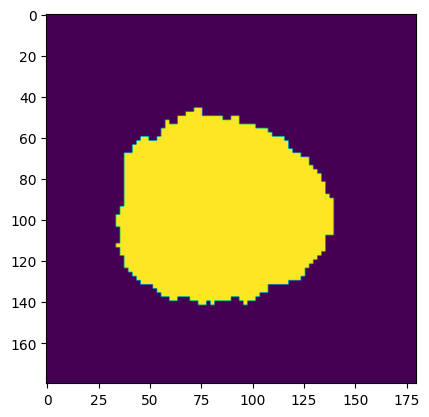

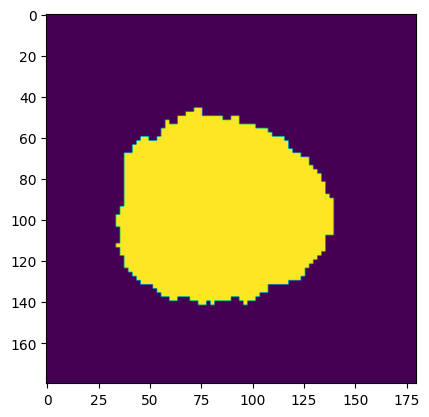

In [21]:
subj = '04843'


subjects_lr, subjects_t1, subjects_masks, transform_lr = load_data_cardiff("../fromCardiff/FastFile-4AfUcztmNtzTwDXb/procd", [subj], pads = [(0, 0), (0, 0), (0, 0), (0,0)])

lowres_input = subjects_lr[0]
t1_input = subjects_t1[0]
mask_input = subjects_masks[0]


In [22]:
print(lowres_input.shape)
print(lowres_input[:,:,:,:].shape)
print(t1_input.shape)

(90, 90, 90, 6)
(90, 90, 90, 6)
(180, 180, 180, 8)


In [23]:
np.unique(mask_input)

array([False,  True])

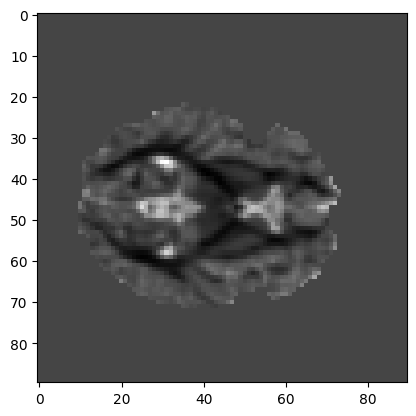

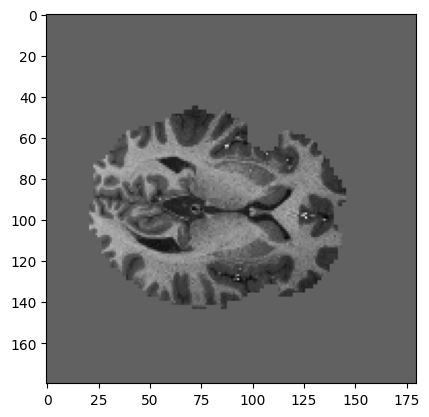

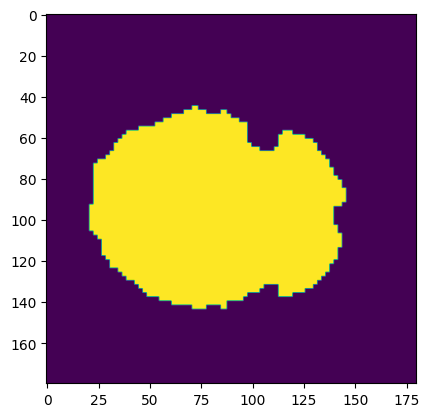

In [24]:
plt.imshow(lowres_input[:,:,45,0], cmap='gray')
plt.figure()
plt.imshow(t1_input[:,:,90,0], cmap='gray')
plt.figure()


plt.imshow(mask_input[:,:,90])
# plt.figure()
# plt.imshow(zoom(np.array(mask_input, dtype=float), 2, mode='nearest')[:,:,120])

In [10]:
# generator_nopatch = None

# generator_nopatch = ESRGAN.srgan_gen_multmode(ishape = [lowres_input.shape[0]//2+8, lowres_input.shape[1]//2, lowres_input.shape[2]//2+8, lowres_input.shape[3]],
#                                               ishape_t1 = [t1_input.shape[0]+16, t1_input.shape[1], t1_input.shape[2]+16, t1_input.shape[3]])

In [11]:
# generator_nopatch.inputs[0].shape, generator_nopatch.outputs[0].shape

In [25]:
print(mask_input.shape)

(180, 180, 180)


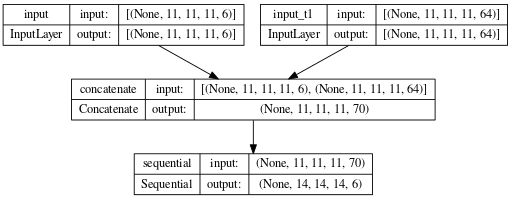

In [26]:
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [46]:
s = 6

lowres_input_ds = lowres_input

(xsize, ysize, zsize, comp) = lowres_input_ds.shape

print(xsize * 2, ysize * 2, zsize * 2)

result_image = np.zeros((xsize*2, ysize*2, zsize*2, comp))
result_image_2 = np.zeros((xsize*2, ysize*2, zsize*2, comp))

# result_image = np.zeros((xsize, ysize, zsize, comp))

# recon_indx = [(i, j, k) for k in np.arange(p_size_i+e_or_o,
#                                            zsize-p_size_i+e_or_o,
#                                            2*p_size_o+e_or_o-4)
#                         for j in np.arange(p_size_i+e_or_o,
#                                            ysize-p_size_i+e_or_o,
#                                            2*p_size_o+e_or_o-4)
#                         for i in np.arange(p_size_i+e_or_o,
#                                            xsize-p_size_i+e_or_o,
#                                            2*p_size_o+e_or_o-4)]

recon_indx = [(i, j, k) for k in np.arange(p_size_i+e_or_o,
                                           zsize-p_size_i+e_or_o,
                                           2*p_size_o+e_or_o)
                        for j in np.arange(p_size_i+e_or_o,
                                           ysize-p_size_i+e_or_o,
                                           2*p_size_o+e_or_o)
                        for i in np.arange(p_size_i+e_or_o,
                                           xsize-p_size_i+e_or_o,
                                           2*p_size_o+e_or_o)]

for (i, j, k) in tqdm(recon_indx):

    if (i - p_size_i < 0 or j - p_size_i < 0 or k - p_size_i < 0):
        continue

    if (i + p_size_i >= xsize or j + p_size_i >= ysize or k + p_size_i >= zsize):
        continue

    if np.max(mask_input[::2,::2,::2][i - p_size_i : i + p_size_i,
                                      j - p_size_i : j + p_size_i,
                                      k - p_size_i : k + p_size_i]) != 1:
        continue

    lr_patch_samp = np.zeros((2 * p_size_i + e_or_o, 2 * p_size_i + e_or_o, 2 * p_size_i + e_or_o, 70))

    lr_patch =  lowres_input_ds[
                        i - p_size_i : i + p_size_i + e_or_o,
                        j - p_size_i : j + p_size_i + e_or_o,
                        k - p_size_i : k + p_size_i + e_or_o,:]

    t1_patch =  t1_input[
                        2*(i - p_size_i - e_or_o) : 2*(i + p_size_i),
                        2*(j - p_size_i - e_or_o) : 2*(j + p_size_i),
                        2*(k - p_size_i - e_or_o) : 2*(k + p_size_i),:]

    # t1_patch = np.random.randn(2*p_size_i + 2*(p_size_i + e_or_o), 2*p_size_i + 2*(p_size_i + e_or_o), 2*p_size_i + 2*(p_size_i + e_or_o), 8)

    # lr_patch_samp[...,:6] = lr_patch

    # lr_patch_samp[...,6:] = space_to_depth(t1_patch)

    # lr_patch = lr_patch_samp
    

    output_patch = generator([lr_patch[None,...], space_to_depth(t1_patch)[None,...]], training=False)


    result_image[2*(i - p_size_o) : 2*(i + p_size_o + e_or_o),
                 2*(j - p_size_o) : 2*(j + p_size_o + e_or_o),
                 2*(k - p_size_o) : 2*(k + p_size_o + e_or_o), :] = (output_patch[0,:,:,:,:])

    # lr_patch = 0 * lr_patch
    
    t1_patch = np.zeros((2*p_size_i + 2*(p_size_i + e_or_o), 
                         2*p_size_i + 2*(p_size_i + e_or_o), 
                         2*p_size_i + 2*(p_size_i + e_or_o), 8))

    # t1_patch = np.random.randn(t1_patch.shape[0], t1_patch.shape[1], t1_patch.shape[2], t1_patch.shape[3])

    output_patch = generator([lr_patch[None,...], space_to_depth(t1_patch)[None,...]], training=False)

    # output_patch = generator([lr_patch[None,...], t1_patch[None,...]], training=False)
    
    result_image_2[2*(i - p_size_o) : 2*(i + p_size_o + e_or_o),
                 2*(j - p_size_o) : 2*(j + p_size_o + e_or_o),
                 2*(k - p_size_o) : 2*(k + p_size_o + e_or_o), :] = (output_patch[0,:,:,:,:])

result_image[mask_input == 0] = 0
result_image_2[mask_input == 0] = 0
    

180 180 180


100%|██████████████████████████████████████| 1728/1728 [00:04<00:00, 355.42it/s]


[-6.6384325  -6.52919865 -6.4987731  ...  7.8658514   8.11327267
  8.16907024]


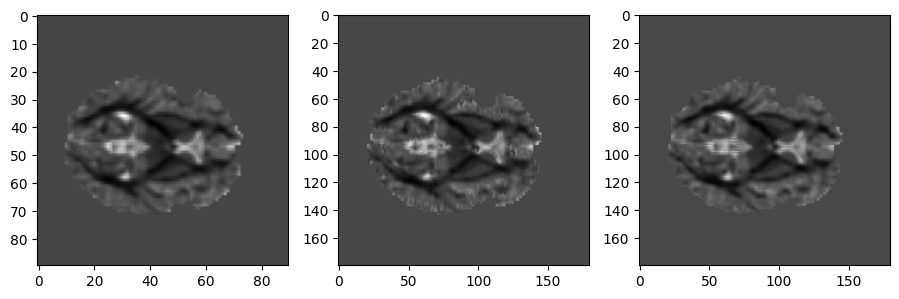

In [47]:
zdim = 90
channel = 0

# plt.imshow(lowres_input[:,:,zdim,channel], cmap='gray')
# plt.figure()
# plt.imshow(hires_output[:,:,zdim,channel], cmap='gray')
# plt.figure()
# plt.imshow(result_image[:,:,zdim,channel], cmap='gray')

print(np.unique(result_image))

fig = plt.figure(figsize=(11,16))

fig.add_subplot(1,3,1)
plt.imshow(lowres_input[:,:,zdim//2,channel], cmap='gray')#,vmax=2)
fig.add_subplot(1,3,2)
plt.imshow(result_image[:,:,zdim,channel], cmap='gray')
fig.add_subplot(1,3,3)
plt.imshow(result_image_2[:,:,zdim,channel], cmap='gray')

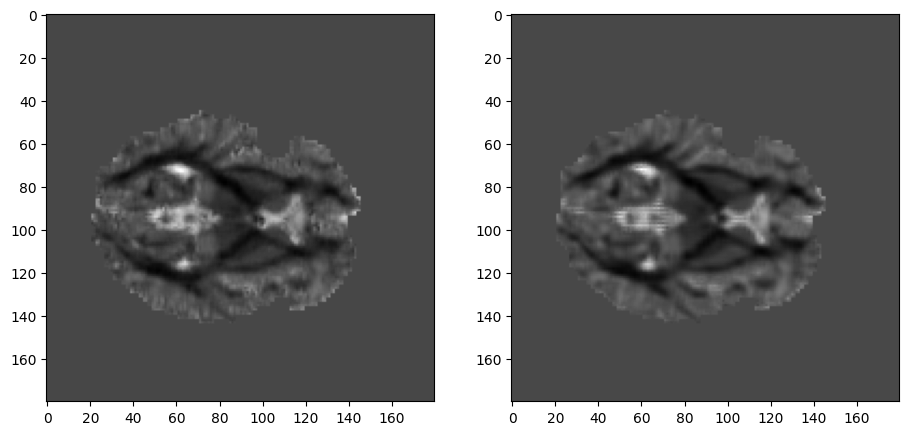

In [48]:
fig = plt.figure(figsize=(11,16))

fig.add_subplot(1,2,1)
plt.imshow(result_image[:,:,zdim,channel], cmap='gray')
fig.add_subplot(1,2,2)
plt.imshow(result_image_2[:,:,zdim,channel], cmap='gray')

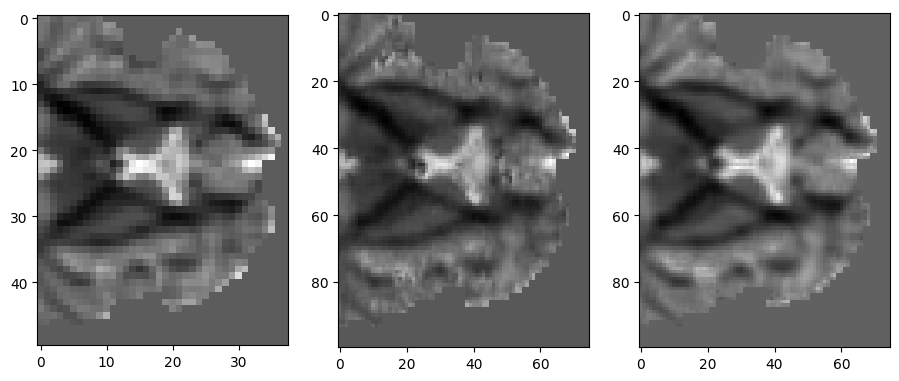

In [49]:
fig = plt.figure(figsize=(11,16))


fig.add_subplot(1,3,1)
plt.imshow(lowres_input[50//2:150//2,75//2:150//2,zdim//2,channel], cmap='gray')
fig.add_subplot(1,3,2)
plt.imshow(result_image[50:150,75:150,zdim,channel], cmap='gray')
fig.add_subplot(1,3,3)
plt.imshow(result_image_2[50:150,75:150,zdim,channel], cmap='gray')

In [50]:
lr_act = np.pad(subjects_lr[0], ((0,0), (0,0), (0,0), (2,0)), mode='constant')
hr_pred = np.pad(result_image, ((0,0), (0,0), (0,0), (2,0)), mode='constant')

for ch in range(2,8):
    # lr_act[...,ch] = zoom(lowres_input[::2,::2,::2,ch-2], 2) * transform_lr[0][ch-2,1] + transform_lr[0][ch-2,0]
    # lr_act[mask_input == 0] = 0
    # hr_act[...,ch] = hires_input[...,ch-2] * transform_hr[0][ch-2,1] + transform_hr[0][ch-2,0]
    # hr_act[mask_input == 0] = 0
    # hr_pred[...,ch] = result_image[...,ch-2] * transform_lr[0][ch-2,1] + transform_lr[0][ch-2,0]
    # hr_pred[mask_input == 0] = 0

    # lr_act[...,ch] = zoom(lowres_input[::2,::2,::2,ch-2], 2) * transform_lr[0][ch-2,1] + transform_lr[0][ch-2,0]
    # lr_act[binary_erosion(mask_input, structure=np.ones((5,5,5),np.uint8),iterations = 1) == 0] = 0
    # hr_act[...,ch] = hires_input[...,ch-2] * transform_hr[0][ch-2,1] + transform_hr[0][ch-2,0]
    # hr_act[binary_erosion(mask_input, structure=np.ones((5,5,5),np.uint8),iterations = 1) == 0] = 0
    # hr_pred[...,ch] = result_image[...,ch-2] * transform_lr[0][ch-2,1] + transform_lr[0][ch-2,0]
    # hr_pred[binary_erosion(mask_input, structure=np.ones((5,5,5),np.uint8),iterations = 1) == 0] = 0

    lr_act[...,ch] = zoom(lowres_input[::2,::2,::2,ch-2], 2) * transform_lr[0][ch-2,1] + transform_lr[0][ch-2,0]
    lr_act[mask_input[::2,::2,::2] == 0] = 0
    hr_pred[...,ch] = result_image[...,ch-2] * transform_lr[0][ch-2,1] + transform_lr[0][ch-2,0]
    hr_pred[mask_input == 0] = 0



In [51]:
[XSIZE, YSIZE, ZSIZE, dim] = hr_pred.shape

md_lr, fa_lr, cfa_lr = data_utils.calc_MD_FA_CFA(lr_act[:,:,:,:], XSIZE//2, YSIZE//2, ZSIZE//2)
md_gen, fa_gen, cfa_gen = data_utils.calc_MD_FA_CFA(hr_pred, XSIZE, YSIZE, ZSIZE)

100%|█████████████████████████████████████████| 180/180 [00:20<00:00,  8.72it/s]


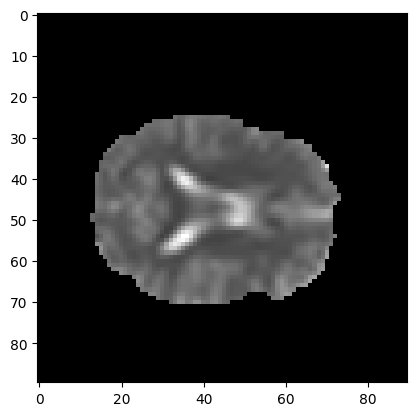

In [52]:
from scipy.io import savemat

plt.imshow(md_lr[:,:,50], cmap='gray')

savemat("./MD.mat", {'MD': md_lr})

In [53]:
print(XSIZE, YSIZE, ZSIZE)

180 180 180


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


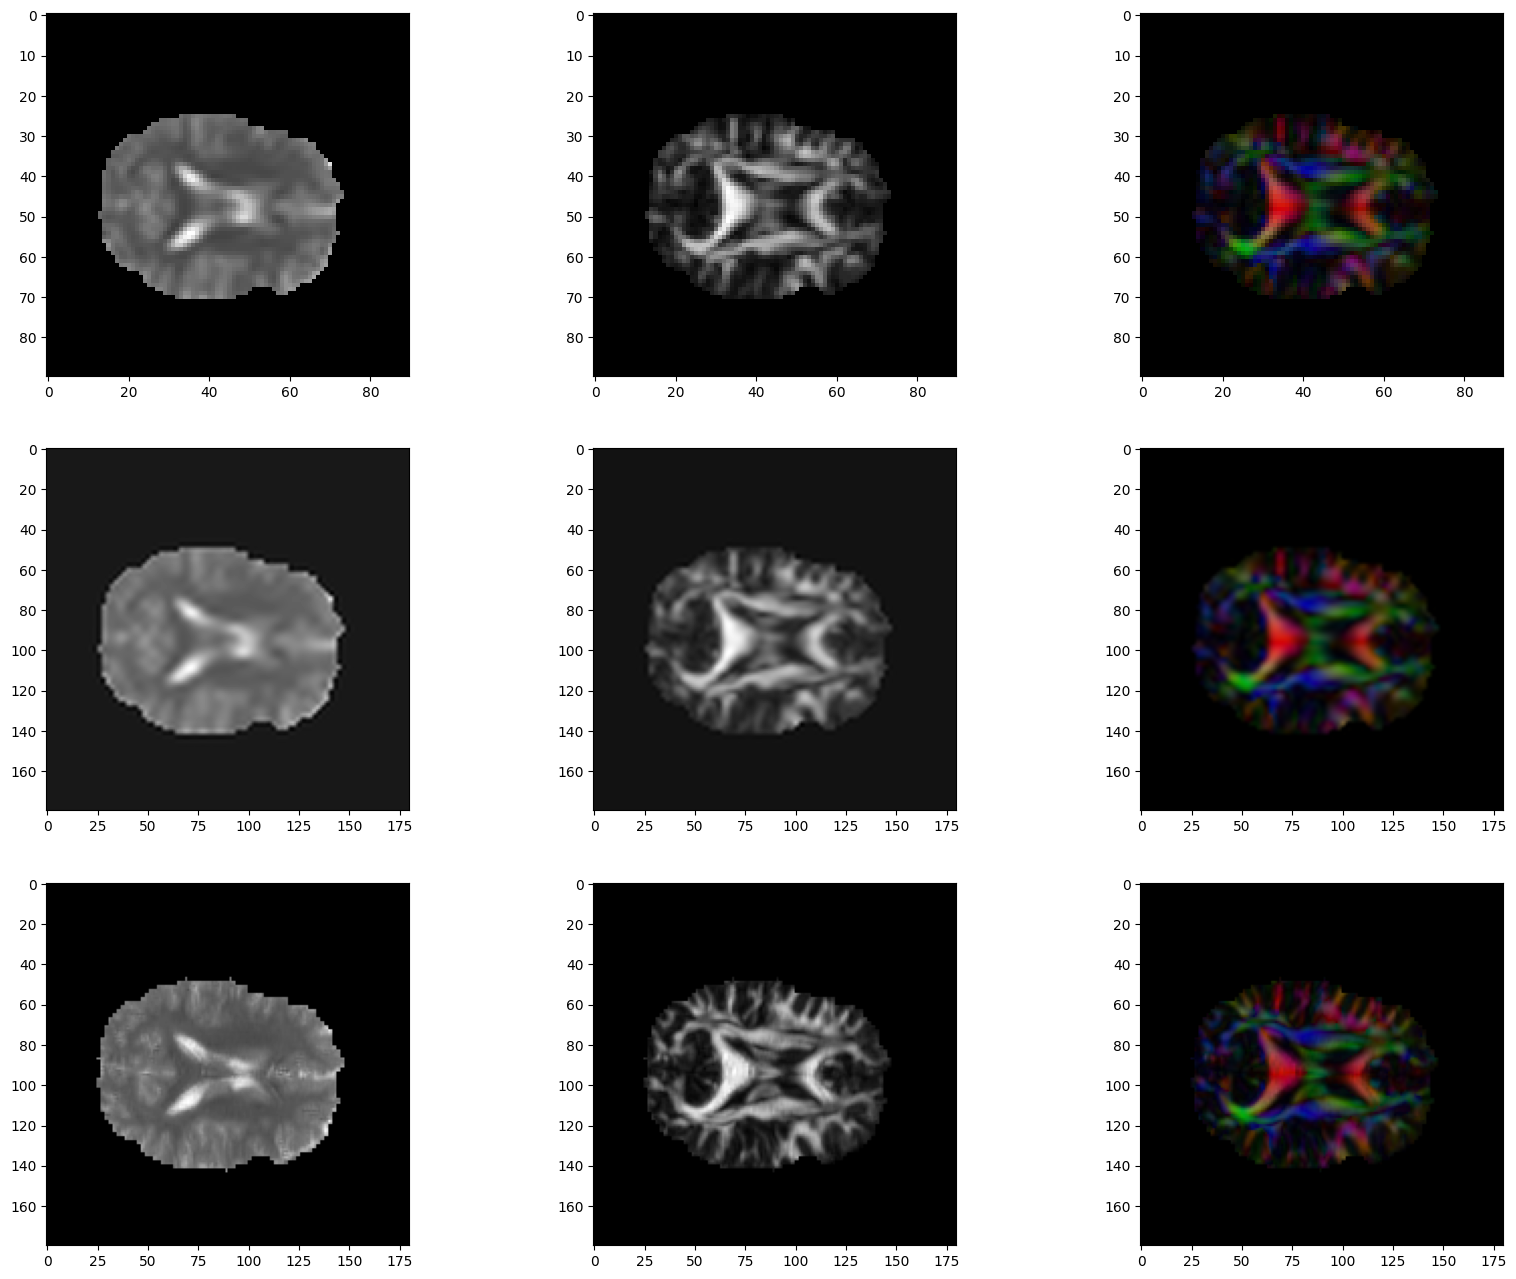

In [60]:
zdim = 100

fig = plt.figure(figsize=(20,16))


fig.add_subplot(3,3,1)
plt.imshow(md_lr[:,:,zdim//2], cmap='gray')

fig.add_subplot(3,3,2)
plt.imshow(fa_lr[:,:,zdim//2], cmap='gray')

fig.add_subplot(3,3,3)
plt.imshow(cfa_lr[:,:,zdim//2], vmax=1)

fig.add_subplot(3,3,4)
plt.imshow(zoom(md_lr[:,:,zdim//2], 2), cmap='gray')

fig.add_subplot(3,3,5)
plt.imshow(zoom(fa_lr[:,:,zdim//2], 2), cmap='gray')

fig.add_subplot(3,3,6)
plt.imshow(zoom(cfa_lr[:,:,zdim//2], (2, 2, 1)), vmax=1)

fig.add_subplot(3,3,7)
plt.imshow(md_gen[:,:,zdim], cmap='gray')

fig.add_subplot(3,3,8)
plt.imshow(fa_gen[:,:,zdim], cmap='gray')

fig.add_subplot(3,3,9)
plt.imshow(cfa_gen[:,:,zdim], vmax=1)

fig.savefig("figure.png")